In [1]:
import numpy as np 
import pandas as pd 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.metrics import mean_squared_log_error
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from statsmodels.graphics.tsaplots import plot_pacf

import optuna
from optuna.samplers import TPESampler

In [2]:
train = pd.read_csv('train.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)
test = pd.read_csv('test.csv',index_col='id', parse_dates = ['date'], infer_datetime_format = True)

In [3]:
train_test = pd.concat([train, test], ignore_index=True)

In [4]:
train_test

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,2013-01-01,1,BABY CARE,0.0,0
2,2013-01-01,1,BEAUTY,0.0,0
3,2013-01-01,1,BEVERAGES,0.0,0
4,2013-01-01,1,BOOKS,0.0,0
...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1
3029396,2017-08-31,9,PREPARED FOODS,NaN,0
3029397,2017-08-31,9,PRODUCE,NaN,1
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9


In [5]:
#change date datatype as datetime
train_test.date = pd.to_datetime(train_test.date)

train_test['year'] = train_test.date.dt.year
train_test['month'] = train_test.date.dt.month
train_test['dayofmonth'] = train_test.date.dt.day
train_test['dayofweek'] = train_test.date.dt.dayofweek
train_test['dayname'] = train_test.date.dt.strftime('%A')

In [6]:
oil = pd.read_csv('oil.csv', parse_dates = ['date'], infer_datetime_format = True, index_col = 'date').to_period('D')

In [7]:
oil['avg_oil_7'] = oil['dcoilwtico'].rolling(7).mean()

In [8]:
oil

,dcoilwtico,avg_oil_7
date,,
2013-01-01,NaN,NaN
2013-01-02,93.14,NaN
2013-01-03,92.97,NaN
2013-01-04,93.12,NaN
2013-01-07,93.20,NaN
...,...,...
2017-08-25,47.65,47.720000
2017-08-28,46.40,47.624286
2017-08-29,46.46,47.320000


In [9]:
trends = pd.DataFrame(index = pd.date_range('2013-01-01','2017-08-31')).to_period('D')
trends = trends.join(oil, how='outer')
#to understand fillna https://www.geeksforgeeks.org/python-pandas-dataframe-fillna-to-replace-null-values-in-dataframe/
trends['avg_oil_7'].fillna(method = 'ffill', inplace = True)
trends.dropna(inplace = True)

In [10]:
trends

,dcoilwtico,avg_oil_7
2013-01-10,93.81,93.218571
2013-01-11,93.60,93.284286
2013-01-14,94.27,93.470000
2013-01-15,93.26,93.490000
2013-01-16,94.28,93.644286
...,...,...
2017-08-25,47.65,47.720000
2017-08-28,46.40,47.624286
2017-08-29,46.46,47.320000
2017-08-30,45.96,47.115714


C:\Users\tompe\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


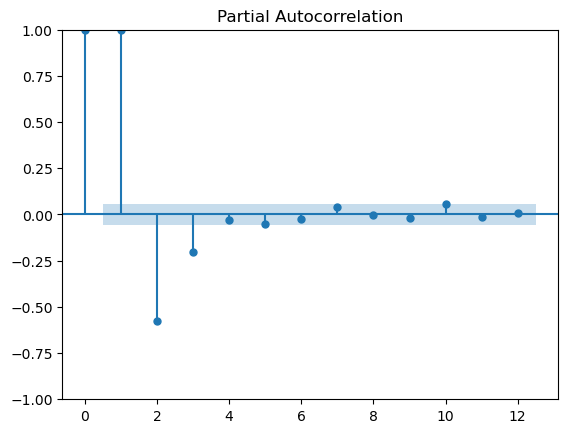

In [11]:
_ = plot_pacf(trends.avg_oil_7, lags = 12)

In [12]:
# Adding lages based on the auto correlation plot (up to 5 will be reasonable for the 7 day rolling average)
n_lags = 3
for l in range(1, n_lags+1):
    trends[f'oil_lags7_{l}'] = trends.avg_oil_7.shift(l)
trends.dropna(inplace = True)
trends.count()

dcoilwtico     1166
avg_oil_7      1166
oil_lags7_1    1166
oil_lags7_2    1166
oil_lags7_3    1166
dtype: int64

In [13]:
trends['date_str'] = trends.index.astype(str)
trends.drop('dcoilwtico', axis=1, inplace=True)

In [14]:
trends

,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3,date_str
2013-01-15,93.490000,93.470000,93.284286,93.218571,2013-01-15
2013-01-16,93.644286,93.490000,93.470000,93.284286,2013-01-16
2013-01-17,93.970000,93.644286,93.490000,93.470000,2013-01-17
2013-01-18,94.331429,93.970000,93.644286,93.490000,2013-01-18
2013-01-22,94.331429,94.331429,93.970000,93.644286,2013-01-22
...,...,...,...,...,...
2017-08-25,47.720000,47.598571,47.645714,47.522857,2017-08-25
2017-08-28,47.624286,47.720000,47.598571,47.645714,2017-08-28
2017-08-29,47.320000,47.624286,47.720000,47.598571,2017-08-29
2017-08-30,47.115714,47.320000,47.624286,47.720000,2017-08-30


In [15]:
#filling missing data
oil = oil.interpolate(method='linear')
#the first row is still missing the value
oil.iloc[0] = oil.iloc[1]

#some days are skipped. Filling up the gap.

start_date = train_test.date.min() 
# from beggining of the train date and the end of test date
number_of_days = 1704 #1703
date_list = [(start_date + datetime.timedelta(days = day)).isoformat() for day in range(number_of_days)]

date = (pd.Series(date_list)).to_frame()
date.columns = ['date']
date.date = pd.to_datetime(date.date)
date['date_str'] = date.date.astype(str)
oil['date_str'] = oil.index.astype(str)

oil = pd.merge(date,oil,how='left',on='date_str')
oil = oil.set_index('date').dcoilwtico.interpolate(method='linear').to_frame()
oil['date_str'] = oil.index.astype(str)

In [16]:
oil

,dcoilwtico,date_str
date,,
2013-01-01,93.140000,2013-01-01
2013-01-02,93.140000,2013-01-02
2013-01-03,92.970000,2013-01-03
2013-01-04,93.120000,2013-01-04
2013-01-05,93.146667,2013-01-05
...,...,...
2017-08-27,46.816667,2017-08-27
2017-08-28,46.400000,2017-08-28
2017-08-29,46.460000,2017-08-29


In [17]:
# add oil price to the train_test date
train_test['date_str'] = train_test.date.astype(str)
train_test = pd.merge(train_test,oil,how='left',on='date_str')

In [18]:
train_test = pd.merge(train_test,trends,how='left',on='date_str')
train_test.drop(columns='date_str',axis=1,inplace=True)

In [19]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,dcoilwtico,avg_oil_7,oil_lags7_1,oil_lags7_2,oil_lags7_3
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,93.14,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,47.26,47.06,47.115714,47.32,47.624286


In [20]:
train_test['onpromo_7'] = train_test['onpromotion'].rolling(7).mean()
train_test['onpromo_28'] = train_test['onpromotion'].rolling(28).mean()

In [21]:
train_test['onpromo_7'].fillna(0, inplace=True)
train_test['onpromo_28'].fillna(0, inplace=True)

In [22]:
stores = pd.read_csv('stores.csv',index_col='store_nbr')
train_test = pd.merge(train_test,stores,how='left',on='store_nbr')

In [23]:
holiday = pd.read_csv('holidays_events.csv')
holiday.query('transferred==True')

# transferred day is not celebrated
holiday = holiday.query('transferred ==False')
holiday.description = holiday.description.str.replace('Traslado ','')

#national
national = holiday.query('locale=="National"')
day_off = national.query('type!="Work Day" or type!="Event"').set_index('date')['description'].to_dict()
train_test['date_str'] = train_test.date.astype(str)
train_test['national_holiday'] = [1 if a in day_off else 0 for a in train_test.date_str]

event = national.query('type=="Event"').set_index('date')['description'].to_dict()
train_test['national_event'] =[1 if a in event else 0 for a in train_test.date_str]

work_day = national.query('type=="Work Day"').set_index('date')['description'].to_dict()
train_test['national_workday'] = [1 if a in work_day else 0 for a in train_test.date_str]

#weekend
train_test['weekend'] = [1 if a>=5 else 0 for a in train_test.dayofweek]

In [24]:
#locale
#locale is corresponding to city of train_df
local = holiday.query('locale=="Local"')
local_dic = local.set_index('date').locale_name.to_dict()
train_test['local_holiday']=[1 if b in local_dic and local_dic[b]== a else 0 for a,b in zip(train_test.city,train_test.date_str)]

In [25]:
#Regional
#Regional is corresonding to state of train_df
regional = holiday.query('locale=="Regional"')
regional_dic = regional.set_index('date').locale_name.to_dict()
train_test['regional_holiday']= [1 if b in regional_dic and regional_dic[b]== a else 0 for a,b in zip(train_test.state,train_test.date_str)]

In [26]:
train_test

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,state,type,cluster,date_str,national_holiday,national_event,national_workday,weekend,local_holiday,regional_holiday
0,2013-01-01,1,AUTOMOTIVE,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
1,2013-01-01,1,BABY CARE,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
2,2013-01-01,1,BEAUTY,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
3,2013-01-01,1,BEVERAGES,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
4,2013-01-01,1,BOOKS,0.0,0,2013,1,1,1,Tuesday,...,Pichincha,D,13,2013-01-01,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,POULTRY,NaN,1,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029396,2017-08-31,9,PREPARED FOODS,NaN,0,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029397,2017-08-31,9,PRODUCE,NaN,1,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0
3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,2017,8,31,3,Thursday,...,Pichincha,B,6,2017-08-31,0,0,0,0,0,0


In [27]:
len(train_test.query('date_str=="2013-01-01"'))

1782

In [28]:
train_test.sales = np.log1p(train_test.sales)

To look at creating forward lags for sales for one week, the 16 days needed for the prediction, and then 6 days past the 16th day (a forward week), for one month (28, 30, 31 days), and one year. Since each day has 1782 rows (stores times families), each value is multiplied by 1782. 

In [29]:
train_test['Istest'] = False

#remove leap year day
#train_test = train_test.query('date_str !="2016-02-29"')

train_test['Lag_7'] = train_test['sales'].shift(1782*7)

train_test['Lag_16'] = train_test['sales'].shift(1782*16)
train_test['Lag_17'] = train_test['sales'].shift(1782*17)
train_test['Lag_18'] = train_test['sales'].shift(1782*18)
train_test['Lag_19'] = train_test['sales'].shift(1782*19)
train_test['Lag_20'] = train_test['sales'].shift(1782*20)
train_test["Lag_21"] = train_test['sales'].shift(1782*21)
train_test['Lag_22'] = train_test['sales'].shift(1782*22)

train_test['Lag_28'] = train_test['sales'].shift(1782*28)
train_test['Lag_30'] = train_test['sales'].shift(1782*30)
train_test['Lag_31'] = train_test['sales'].shift(1782*31)

train_test['Lag_365'] = train_test['sales'].shift(1782*365)

train_test = train_test.query('Istest==False')

An exponential moving average is a type of moving average that gives more weight to recent observations, which means it’s able to capture recent trends more quickly. Alpha, which ranges from 0 to 1, determines how important the current observation is in the calculation of the EWMA. Alpha represents the degree of weighting decrease and is a constant smoothing factor. A higher alpha discounts older data faster thereby placing greater relevance on your more current data.

Below this is done for a range of alphas between 0.95 and 0.5, and for 1 day, 1 week, and one month. 

In [30]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            feature_name = 'sales_ewm_alpha_' + str(alpha).replace(".", "") + '_lag_' + str(lag)
            dataframe[feature_name] = dataframe.groupby(["store_nbr", "family"])['sales'].\
                transform(lambda x: x.shift(lag).ewm(alpha=alpha, min_periods=1).mean())
    return dataframe

In [31]:
alphas = [0.95, 0.8, 0.65, 0.5]
lags =[1, 7,30]
train_test = ewm_features(train_test, alphas, lags)

From the correlation data it appears the lowest alphas and lowest lags have the highest correlations to sales. Which means the older data is still important as part of the EWM calculations. 

In [32]:
corr = train_test.corr()
corr['sales'].sort_values(ascending=False)

sales                         1.000000
sales_ewm_alpha_05_lag_1      0.975231
sales_ewm_alpha_065_lag_1     0.973496
sales_ewm_alpha_08_lag_1      0.971192
sales_ewm_alpha_05_lag_7      0.971186
sales_ewm_alpha_065_lag_7     0.970779
sales_ewm_alpha_08_lag_7      0.969665
sales_ewm_alpha_095_lag_1     0.968111
sales_ewm_alpha_095_lag_7     0.967665
Lag_7                         0.966752
Lag_21                        0.947122
Lag_16                        0.941619
Lag_17                        0.939454
Lag_20                        0.939114
Lag_18                        0.938127
Lag_28                        0.937857
Lag_19                        0.937607
Lag_22                        0.935959
sales_ewm_alpha_05_lag_30     0.934552
sales_ewm_alpha_065_lag_30    0.931726
sales_ewm_alpha_08_lag_30     0.928695
sales_ewm_alpha_095_lag_30    0.925129
Lag_30                        0.923753
Lag_31                        0.922037
Lag_365                       0.850742
onpromotion              

In [33]:
lags = ['Lag_7','Lag_16','Lag_17','Lag_18','Lag_19','Lag_20','Lag_21','Lag_22','Lag_28', 'Lag_30','Lag_31','Lag_365',
       'oil_lags7_1', 'oil_lags7_2', 'oil_lags7_3', 'avg_oil_7', 'sales_ewm_alpha_095_lag_1', 'sales_ewm_alpha_095_lag_7',
        'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_08_lag_1', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_30',
        'sales_ewm_alpha_065_lag_1', 'sales_ewm_alpha_065_lag_7', 'sales_ewm_alpha_065_lag_30', 'sales_ewm_alpha_05_lag_1',
        'sales_ewm_alpha_05_lag_7', 'sales_ewm_alpha_05_lag_30']

In [34]:
train_test[lags]=train_test[lags].fillna(0)

In [35]:
print(train_test.columns.tolist())

['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'year', 'month', 'dayofmonth', 'dayofweek', 'dayname', 'dcoilwtico', 'avg_oil_7', 'oil_lags7_1', 'oil_lags7_2', 'oil_lags7_3', 'onpromo_7', 'onpromo_28', 'city', 'state', 'type', 'cluster', 'date_str', 'national_holiday', 'national_event', 'national_workday', 'weekend', 'local_holiday', 'regional_holiday', 'Istest', 'Lag_7', 'Lag_16', 'Lag_17', 'Lag_18', 'Lag_19', 'Lag_20', 'Lag_21', 'Lag_22', 'Lag_28', 'Lag_30', 'Lag_31', 'Lag_365', 'sales_ewm_alpha_095_lag_1', 'sales_ewm_alpha_095_lag_7', 'sales_ewm_alpha_095_lag_30', 'sales_ewm_alpha_08_lag_1', 'sales_ewm_alpha_08_lag_7', 'sales_ewm_alpha_08_lag_30', 'sales_ewm_alpha_065_lag_1', 'sales_ewm_alpha_065_lag_7', 'sales_ewm_alpha_065_lag_30', 'sales_ewm_alpha_05_lag_1', 'sales_ewm_alpha_05_lag_7', 'sales_ewm_alpha_05_lag_30']


In [36]:
FEATURES = train_test.columns.tolist()

no_features = ('date', 'family', 'sales', 'dayname', 'date_str', 'Istest')

for i in no_features:
    FEATURES.remove(i)

TARGET =['sales']

In [37]:
categories = ['family','city','state', 'type']
for i in categories:
    encoder = preprocessing.LabelEncoder()
    train_test[i] = encoder.fit_transform(train_test[i])

In [38]:
train = train_test[train_test['sales'].notnull()].copy()
test = train_test[train_test['sales'].isnull()].drop(['sales'],axis=1)

In [39]:
train = train.query("date >= '2016-01-01' ")

In [40]:
train

,date,store_nbr,family,sales,onpromotion,year,month,dayofmonth,dayofweek,dayname,...,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_08_lag_1,sales_ewm_alpha_08_lag_7,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_065_lag_1,sales_ewm_alpha_065_lag_7,sales_ewm_alpha_065_lag_30,sales_ewm_alpha_05_lag_1,sales_ewm_alpha_05_lag_7,sales_ewm_alpha_05_lag_30
1945944,2016-01-01,1,0,0.000000,0,2016,1,1,4,Friday,...,1.317202,1.803400,1.677389,1.122943,1.817994,1.697249,0.973111,1.827742,1.657195,0.892811
1945945,2016-01-01,1,1,0.000000,0,2016,1,1,4,Friday,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1945946,2016-01-01,1,2,0.000000,0,2016,1,1,4,Friday,...,1.943741,0.178375,1.221152,1.908997,0.274128,1.293594,1.828294,0.374116,1.354975,1.702942
1945947,2016-01-01,1,3,0.000000,0,2016,1,1,4,Friday,...,7.804765,7.711394,7.735110,7.773221,7.703508,7.747519,7.724412,7.668357,7.747519,7.670928
1945948,2016-01-01,1,4,0.000000,0,2016,1,1,4,Friday,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3000883,2017-08-15,9,28,6.084802,0,2017,8,15,1,Tuesday,...,6.344168,5.724007,5.943887,6.320788,5.778189,6.000674,6.283348,5.829966,6.062661,6.230597
3000884,2017-08-15,9,29,5.046987,1,2017,8,15,1,Tuesday,...,4.849691,4.737019,4.757764,4.858467,4.737446,4.783436,4.851238,4.742214,4.803638,4.827482
3000885,2017-08-15,9,30,7.791824,148,2017,8,15,1,Tuesday,...,7.613556,7.245679,7.681609,7.578174,7.263540,7.639393,7.530851,7.272816,7.593833,7.479115
3000886,2017-08-15,9,31,4.804021,8,2017,8,15,1,Tuesday,...,0.052401,5.213560,5.120861,0.188557,5.196824,5.112156,0.313338,5.161940,5.098202,0.446829


In [41]:
X_train,X_val,y_train,y_val = train_test_split(train,train[TARGET],test_size=0.05,shuffle=False)

In [42]:
def cat_objective(trial):
    param = {  
        
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "learning_rate": trial.suggest_float("learning_rate", .001, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg", .0001, 25.0),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100)
            }        

    
    model = CatBoostRegressor(**param)
    model.fit(X_train[FEATURES], y_train, eval_set=[(X_val[FEATURES], y_val)], verbose=0)
    y_pred = model.predict(X_val[FEATURES])
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

In [43]:
study_cat = optuna.create_study(sampler=TPESampler(), direction='minimize')
study_cat.optimize(cat_objective, n_trials=1000)
print('Number of finished trials:', len(study_cat.trials))
print('Best trial:', study_cat.best_trial.params)

[I 2023-08-03 16:00:23,302] A new study created in memory with name: no-name-60108619-620b-4147-9c2e-8bbf0125d9a4
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 16:00:50,618] Trial 0 finished with value: 0.4266224293729251 and parameters: {'colsample_bylevel': 0.016668387643267127, 'learning_rate': 0.07010837335426787, 'depth': 11, 'l2_leaf_reg': 15.599998136274172, 'subsample': 0.3693091236635824, 'min_data_in_leaf': 4}. Best is trial 0 with value: 0.4266224293729251.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_

[I 2023-08-03 16:08:10,051] Trial 9 finished with value: 0.40157716026589996 and parameters: {'colsample_bylevel': 0.07455290656653658, 'learning_rate': 0.09742537845548377, 'depth': 3, 'l2_leaf_reg': 9.352605529527898, 'subsample': 0.34629973448924434, 'min_data_in_leaf': 15}. Best is trial 1 with value: 0.40093632647355876.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 16:09:09,454] Trial 10 finished with value: 0.3936767672412569 and parameters: {'colsample_bylevel': 0.09854887301092513, 'learning_rate': 0.055346399375402

[I 2023-08-03 16:20:00,636] Trial 19 finished with value: 0.6365775520697073 and parameters: {'colsample_bylevel': 0.04737812824989159, 'learning_rate': 0.0021596674192236667, 'depth': 10, 'l2_leaf_reg': 8.08186091898737, 'subsample': 0.5640189271711689, 'min_data_in_leaf': 85}. Best is trial 17 with value: 0.38892312894861836.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 16:21:43,551] Trial 20 finished with value: 0.39309726085544044 and parameters: {'colsample_bylevel': 0.07958830537503317, 'learning_rate': 0.022691733767

[I 2023-08-03 16:41:27,802] Trial 29 finished with value: 0.3872177497297975 and parameters: {'colsample_bylevel': 0.09953426334459844, 'learning_rate': 0.058424082655962654, 'depth': 12, 'l2_leaf_reg': 2.224103216847938, 'subsample': 0.33879703615195417, 'min_data_in_leaf': 58}. Best is trial 29 with value: 0.3872177497297975.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 16:44:09,064] Trial 30 finished with value: 0.38678872692196625 and parameters: {'colsample_bylevel': 0.09845013300161515, 'learning_rate': 0.062796183246

[I 2023-08-03 17:07:14,277] Trial 39 finished with value: 0.38653473131912836 and parameters: {'colsample_bylevel': 0.08970013829474247, 'learning_rate': 0.07232994482078192, 'depth': 12, 'l2_leaf_reg': 5.482654063034266, 'subsample': 0.26004550652843256, 'min_data_in_leaf': 43}. Best is trial 39 with value: 0.38653473131912836.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 17:08:54,833] Trial 40 finished with value: 0.3879076007144177 and parameters: {'colsample_bylevel': 0.0906716678992502, 'learning_rate': 0.0733724146990

[I 2023-08-03 17:23:54,471] Trial 49 finished with value: 0.38876977527680834 and parameters: {'colsample_bylevel': 0.06866564150982096, 'learning_rate': 0.08351363078713972, 'depth': 11, 'l2_leaf_reg': 8.829947586345517, 'subsample': 0.2945003265213794, 'min_data_in_leaf': 52}. Best is trial 39 with value: 0.38653473131912836.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 17:26:36,548] Trial 50 finished with value: 0.38842781285097766 and parameters: {'colsample_bylevel': 0.08776719784448671, 'learning_rate': 0.071942492872

[I 2023-08-03 17:42:19,987] Trial 59 finished with value: 0.39500915060647823 and parameters: {'colsample_bylevel': 0.08641815365634725, 'learning_rate': 0.07748028525550626, 'depth': 5, 'l2_leaf_reg': 8.769876266340953, 'subsample': 0.17534214434870996, 'min_data_in_leaf': 28}. Best is trial 51 with value: 0.3864530986177249.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 17:43:39,139] Trial 60 finished with value: 0.3898856198283784 and parameters: {'colsample_bylevel': 0.09585672285041176, 'learning_rate': 0.05816883590658

[I 2023-08-03 18:02:01,996] Trial 69 finished with value: 0.38687946058059336 and parameters: {'colsample_bylevel': 0.0899067402400638, 'learning_rate': 0.08694480887269077, 'depth': 11, 'l2_leaf_reg': 4.7917182116913715, 'subsample': 0.4878343625931633, 'min_data_in_leaf': 54}. Best is trial 62 with value: 0.3864482334830561.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 18:03:58,756] Trial 70 finished with value: 0.3875821446758914 and parameters: {'colsample_bylevel': 0.07331386829167783, 'learning_rate': 0.08021890841489

[I 2023-08-03 18:22:48,087] Trial 79 finished with value: 0.3884635084951726 and parameters: {'colsample_bylevel': 0.09130714899183746, 'learning_rate': 0.060155211851588994, 'depth': 10, 'l2_leaf_reg': 8.914739883484607, 'subsample': 0.37899126079283163, 'min_data_in_leaf': 28}. Best is trial 62 with value: 0.3864482334830561.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 18:24:57,864] Trial 80 finished with value: 0.3879117056144575 and parameters: {'colsample_bylevel': 0.07985709470405111, 'learning_rate': 0.0632921185329

[I 2023-08-03 18:43:13,526] Trial 89 finished with value: 0.38735104075595894 and parameters: {'colsample_bylevel': 0.09011558839060617, 'learning_rate': 0.06366971420007882, 'depth': 12, 'l2_leaf_reg': 7.106576766557371, 'subsample': 0.3943295831226459, 'min_data_in_leaf': 32}. Best is trial 81 with value: 0.38639344148959426.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 18:44:54,514] Trial 90 finished with value: 0.38812892653155984 and parameters: {'colsample_bylevel': 0.08237587775034182, 'learning_rate': 0.059836673087

[I 2023-08-03 19:03:41,203] Trial 99 finished with value: 0.4011263751590722 and parameters: {'colsample_bylevel': 0.09799022239851567, 'learning_rate': 0.07446422819329279, 'depth': 3, 'l2_leaf_reg': 9.070961165086688, 'subsample': 0.5424091719550073, 'min_data_in_leaf': 30}. Best is trial 81 with value: 0.38639344148959426.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 19:04:57,237] Trial 100 finished with value: 0.3916552543794396 and parameters: {'colsample_bylevel': 0.09150584521376033, 'learning_rate': 0.06722071372318

[I 2023-08-03 19:24:10,625] Trial 109 finished with value: 0.3867719586027223 and parameters: {'colsample_bylevel': 0.08619866893205883, 'learning_rate': 0.05939355226897896, 'depth': 12, 'l2_leaf_reg': 7.974949618315957, 'subsample': 0.4020142204657855, 'min_data_in_leaf': 63}. Best is trial 81 with value: 0.38639344148959426.
C:\Users\tompe\anaconda3\lib\site-packages\optuna\trial\_trial.py:681: RuntimeWarning: Inconsistent parameter values for distribution with name "colsample_bylevel"! This might be a configuration mistake. Optuna allows to call the same distribution with the same name more than once in a trial. When the parameter values are inconsistent optuna only uses the values of the first call and ignores all following. Using these values: {'step': None, 'low': 0.01, 'high': 0.1, 'log': False}
  warnings.warn(
[I 2023-08-03 19:25:33,803] Trial 110 finished with value: 0.3898739394052384 and parameters: {'colsample_bylevel': 0.08870946600869958, 'learning_rate': 0.063053207570

CatBoostError: (The process cannot access the file because it is being used by another process.) C:/Go_Agent/pipelines/BuildMaster/catboost.git/util/system/file.cpp:857: can't open "catboost_info\\learn\\events.out.tfevents" with mode WrOnly|CreateAlways|Seq (0x00000034)

Trial 81 finished with value: 0.38639344148959426 and parameters: {'colsample_bylevel': 0.09318492276139413, 'learning_rate': 0.06706188765808815, 'depth': 12, 'l2_leaf_reg': 7.307272001355032, 'subsample': 0.39101391206564023, 'min_data_in_leaf': 39}.